## Deconvolution with a panel of methods

We compare the predictive value of CLIMB and a panel of published bulk deconvolution methods: BayesPrism, CiberSortX, MUSIC, BisqueRNA, and NNLS, TAPE, Scaden, and using random proportions as a negative control.

*Note: As CiberSortX deconvolution was obtained via their website interface, we provide the code to produce the tables given as input for CiberSortX, and use here the table containing the processed results of cell type proportions.*


In [ ]:
library(glmnet) ; library(Biobase) ; library(reshape2) ; library(BayesPrism)
library(MuSiC) ; library(SingleCellExperiment) ; library(BisqueRNA)
library(ClimbTheCliff)

In [ ]:
### UPDATE CLIMB ###
detach("package:climb", unload=TRUE)
devtools::install_github('alexdray86/climb', force=T) # Need force=T if already installed ! 
library(climb)
# You can check with sessionInfo() that climb is version 0.0.5 (should be climb_0.0.5)

### Functions 

In [55]:
# METRICS FUNCTIONS
num <- function(x){ return(as.numeric(as.character(x)))}
flatten <- function(x){return(as.vector(as.matrix(x)))}
mse <- function(tr, pr){ return( sum((tr - pr)^2) / length(tr) ) }
rmse <- function(tr, pr){ return( sqrt( sum((tr - pr)^2) / length(tr) ) ) }
scor <- function(tr, pr){ return( cor(tr, pr, method = 'spearman') ) }
pcor <- function(tr, pr){ return( cor(tr, pr, method = 'pearson') ) }
r_square <- function(pr, tr){
    SStot = sum((tr - mean(tr))^2)
    SSres = sum((pr - tr)^2)
    return(1 - SSres / SStot)
}
r_square <- function(pr, tr){
    return( sign(cor(pr,tr))*cor(pr,tr)^2 )
}
### Function to retrieve all metrics from Deconvolution vs True cell-type proportion comparison
comp_rows_and_cols <- function(pred_prop, true_prop){
    pc_l = list() ; sc_l = list()
    rsq_l = list(); rmse_l = list()
    for(i in 1:dim(pred_prop)[1]){
        pc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'pearson')
        sc_l[[i]] = cor(pred_prop[i,], true_prop[i,], method = 'spearman')
        rsq_l[[i]] = max(r_square(pred_prop[i,], true_prop[i,]), -1.0)
        rmse_l[[i]] = rmse(pred_prop[i,], true_prop[i,])
    }
    pc_c = list() ; sc_c = list()
    rsq_c = list(); rmse_c = list()
    for(i in 1:dim(pred_prop)[2]){
        pc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'pearson')
        sc_c[[i]] = cor(pred_prop[,i], true_prop[,i], method = 'spearman')
        rsq_c[[i]] = max(r_square(pred_prop[,i], true_prop[,i]), -1.0)
        rmse_c[[i]] = rmse(pred_prop[,i], true_prop[,i])
    }
    res = list() ; 
    res[[1]] = num(pc_l) ; res[[2]] = num(sc_l)
    res[[3]] = num(rsq_l); res[[4]] = num(rmse_l)
    res[[5]] = num(pc_c) ; res[[6]] = num(sc_c)
    res[[7]] = num(rsq_c); res[[8]] = num(rmse_c)
    res[[9]] = pcor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[10]] = scor(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    res[[11]] = max(r_square(as.vector(num(pred_prop)), as.vector(num(true_prop))), -1.0)
    res[[12]] = rmse(as.vector(num(pred_prop)), as.vector(num(true_prop)))
    return(res)
}
reformat_strings <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', 'minus', vector_string) 
    vector_string <- gsub('\\+', 'plus', vector_string) 
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_strings2 <- function(vector_string){
    # replace plus and minus (e.g. useful for CD34+, CD34- populations)
    vector_string <- gsub('\\-$', '', vector_string) 
    vector_string <- gsub('\\+', '', vector_string) 
    vector_string <- gsub('minus', '', vector_string) 
    vector_string <- gsub('plus', '', vector_string)
    vector_string <- gsub('\\ ', '\\.', vector_string) 
    # remove all special characters
    vector_string <- gsub('[^[:alnum:] ]','',vector_string)
    return(vector_string)
}
reformat_celltypes <- function(celltype_labels){
    celltype_labels <- reformat_strings2(as.vector(celltype_labels))
    celltype_labels <- factor(celltype_labels)
    return(celltype_labels)
}
add_missing_celltypes <- function(tab, celltype_names){
    missing_ct = celltype_names[!celltype_names %in% colnames(tab)]
    if(length(missing_ct)>0){
        for(ct in missing_ct){
            tab_ = cbind(tab, rep(0, dim(tab)[1]))
            colnames(tab_) = c(colnames(tab), ct)
            tab = tab_
        }
    }
    return(tab)
} 

### Function for each deconvolution methods ### 
deconvolution_climb <- function(sc, bulks, true_prop, celltype_names){
    climb_res = climb(sc, bulks)
    climb_prop = climb_res$props.corrected
    rownames(climb_prop) = colnames(bulks)
    climb_prop = add_missing_celltypes(climb_prop, celltype_names)
    return(as.matrix(climb_prop[,celltype_names]))
}
deconvolution_bayesprism <- function(sc, bulks, true_prop, celltype_names){
    myPrism <- new.prism(reference= t(exprs(sc)), 
                         mixture=t(exprs(bulks)), input.type="count.matrix", 
                         cell.type.labels = as.character(sc$cellType), 
                         cell.state.labels = as.character(sc$cellType), 
                         key = NULL,outlier.cut=0.01,outlier.fraction=0.1)
    bp.res <- run.prism(prism = myPrism, n.cores=6)
    bayesprism_prop <- get.fraction (bp=bp.res, which.theta="final",
             state.or.type="type")
    bayesprism_prop = add_missing_celltypes(bayesprism_prop, celltype_names)
    return(as.matrix(bayesprism_prop[,celltype_names]))
}
deconvolution_music <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    music_prop = music.output$Est.prop.weighted
    music_prop = add_missing_celltypes(music_prop, celltype_names)
    return(music_prop[,celltype_names])
}
deconvolution_nnls <- function(sc, bulks, true_prop, celltype_names){
    sce <- SingleCellExperiment(list(counts=exprs(sc)),
                                colData=DataFrame(label=colnames(sc),
                                                  cellType=sc$cellType,
                                                  SubjectName=sc$SubjectName),
                                rowData=DataFrame(gene_name=rownames(sc)))
    music.output = music_prop(bulk.mtx = exprs(bulks), sc.sce = sce, 
                                 clusters = 'cellType',samples = 'SubjectName',verbose = F)
    nnls_prop = music.output$Est.prop.allgene
    nnls_prop = add_missing_celltypes(nnls_prop, celltype_names)
    return(nnls_prop[,celltype_names])
}
deconvolution_bisque <- function(sc, bulks, true_prop, celltype_names){
    bisque.out = BisqueRNA::ReferenceBasedDecomposition(bulks, sc, use.overlap=F)
    bisque_prop = t(bisque.out$bulk.props)
    bisque_prop = add_missing_celltypes(bisque_prop, celltype_names)
    return(bisque_prop[,celltype_names])
}
deconvolution_random <- function(nnls_prop){
    nnls_prop = read.csv(paste0(out_dir, '/nnls_prop.csv'), row.names='X')
    set.seed(1)
    rand_prop = nnls_prop[sample(rownames(nnls_prop)), sample(colnames(nnls_prop))]
    rownames(rand_prop) = rownames(nnls_prop) ; colnames(rand_prop) = colnames(nnls_prop)
    return(rand_prop)
}
write_tables_cibersortx <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING : the following script only writes tables to be used on CiberSortX website
    sc_mat = exprs(sc)
    colnames(sc_mat) = as.character(sc$cellType) # cell-type labels provided as column names
    write.table(sc_mat , paste0(tab_dir,"/TMP_cibersortx_sc_mat.txt"), sep = '\t', quote=F)
    write.table(exprs(bulks), paste0(tab_dir,"/TMP_cibersortx_pbulks.txt"), sep = '\t', quote=F)
    # tables needs to be further processed in bash to add 'Gene' at the start of the file
    # cat <(echo -ne "Gene\t") TMP_cibersortx_pbulks.txt > cibersortx_pbulks.txt
    # cat <(echo -ne "Gene\t") TMP_cibersortx_sc_mat.txt > cibersortx_sc_mat.txt
}
write_tables_tape_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # Write all input tables formatted for TAPE / Scaden
    write.csv(t(exprs(bulks)), paste0(tab_dir, "/tape_scaden_bulks_expr.csv"), quote=F)
    sc_mat_TAPE = exprs(sc)
    sc_mat_TAPE = t(sc_mat_TAPE)
    rownames(sc_mat_TAPE) = sc$cellType
    write.csv(sc_mat_TAPE, paste0(tab_dir, "/tape_scaden_scmat_expr.csv"), quote=F)
}
deconvolution_scaden <- function(sc, bulks, true_prop, celltype_names, tab_dir){
    # WARNING: launching TAPE / Scaden from the command line induces figures popping up
    # which blocks the process (figures have to be closed manually). 
    # To prevent these figures to be made, one can comment lines 103-109,115-119,128-131, 
    # and 172-176 in the file 'tape_scaden_env/lib/python3.7/site-packages/TAPE/utils.py'
    message('Launch Scaden / TAPE deconvolution')
    # Launch bash script that will launch environment and python script
    system(paste0('bash launch_TAPE_and_Scaden.sh ', tab_dir, '/tape_scaden_scmat_expr.csv ',
                  tab_dir, '/tape_scaden_bulks_expr.csv ',
                  '../REVISION_1/data/celltype_expression/TAPE/input/GeneLength.txt ',
                  tab_dir, '/'), wait=TRUE)
}
load_tape_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    tape_prop = read.csv(paste0(tmp_dir,'/tape_a_prop.csv'), row.names = 'X')
    colnames(tape_prop) = reformat_celltypes(colnames(tape_prop))
    tape_prop = add_missing_celltypes(tape_prop, celltype_names)
    tape_prop = tape_prop[,as.character(celltype_names)]
    write.csv(tape_prop, paste0(out_dir,'/tape_prop.csv'), quote=F)
    return(tape_prop)
}
load_scaden_prop <- function(tmp_dir, out_dir, celltype_names){
    celltype_names = reformat_celltypes(celltype_names)
    scaden_prop = read.csv(paste0(tmp_dir,'/scaden_prop.csv'), row.names = 'X')
    colnames(scaden_prop) = reformat_celltypes(colnames(scaden_prop))
    scaden_prop = add_missing_celltypes(scaden_prop, celltype_names)
    scaden_prop = scaden_prop[,as.character(celltype_names)]
    write.csv(scaden_prop, paste0(out_dir,'/scaden_prop.csv'), quote=F)
    return(scaden_prop)
}
load_all_props <- function(odir, include_cibersortx=FALSE){
    tdir = paste0(odir,'/tmp_tabs')
    true_p = read.csv(paste0(odir, '/true_prop.csv'), row.names='X')
    sample_names = row.names(true_p)
    celltype_names = read.csv(paste0(odir, '/celltype_names.csv'))$x
    climb_corrected = read.csv(paste0(odir, '/climb_prop_corrected.csv'), row.names='X')[,celltype_names]
    #climb_init = read.csv(paste0(odir, '/climb_prop_init.csv'), row.names='X')[,celltype_names]
    bayesprism_p = read.csv(paste0(odir, '/bayesprism_prop.csv'), row.names='X')[,celltype_names]
    music_p = read.csv(paste0(odir, '/music_prop.csv'), row.names='X')[,celltype_names]
    nnls_p = read.csv(paste0(odir, '/nnls_prop.csv'), row.names='X')[,celltype_names]
    rand_p = read.csv(paste0(odir, '/rand_prop.csv'), row.names='X')[,celltype_names]
    bisque_p = read.csv(paste0(odir, '/bisque_prop.csv'), row.names='X')[,celltype_names]
    tape_p = load_tape_prop(tdir, odir, celltype_names)
    scaden_p = load_scaden_prop(tdir, odir, celltype_names)
    if(include_cibersortx){
        csx_p = add_missing_celltypes(read.csv(paste0(odir, '/cibersortx_prop.csv'), row.names='Mixture'), celltype_names)[,celltype_names]
        all_p = list(as.matrix(climb_corrected),  as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(csx_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB',  'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    } else {
        all_p = list(as.matrix(climb_corrected),  as.matrix(scaden_p), 
                     as.matrix(tape_p), as.matrix(bayesprism_p), as.matrix(music_p), 
                     as.matrix(nnls_p), as.matrix(bisque_p), as.matrix(rand_p))
        names(all_p) = c('CLIMB', 'Scaden', 'TAPE', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    }
    true_prop_cols = colnames(true_p) ; true_prop_rows = rownames(true_p)
    message(paste0('Checking that all tables have the same cell-type labels: ',suppressWarnings(all(lapply(all_p, function(x) all(colnames(x) == true_prop_cols))))))
    message(paste0('Checking that all tables has the same sample names: ',suppressWarnings(all(lapply(all_p, function(x) all(rownames(x) == true_prop_rows))))))
    return(all_p)
}                                                                                             
make_all_metrics <- function(all_ps, t_prop_f){
    t_prop = as.matrix(read.csv(t_prop_f, row.names = 'X'))
    all_rs = list()
    for(p in 1:length(all_ps)){
        name_p = names(all_ps)[p]
        all_rs[[name_p]] = suppressWarnings(comp_rows_and_cols(all_ps[[p]], t_prop))
        names(all_rs[[name_p]]) = c('PCC_per_sample', 'SCC_per_sample', 'R2_per_sample', 'RMSE_per_sample',
                                    'PCC_per_celltype', 'SCC_per_celltype', 'R2_per_celltype', 'RMSE_per_celltype',
                                    'PCC_overall', 'SCC_overall', 'R2_overall', 'RMSE_overall')
    }
    names(all_rs) = names(all_ps)
    all_rs = all_rs[[c(1,2,4,5,6,8,9,10,12)]]
    return(all_rs)
}

rank_all_metrics <- function(tab){
    median_metrics=list()
    for(i in 1:4){
        median_metrics[[i]] = c(median(tab$CLIMB[[i]], na.rm = T), median(tab$Scaden[[i]], na.rm = T), #median(aml.na2na$CLIMB[[i]]), 
                        median(tab$TAPE[[i]], na.rm = T), median(tab$CiberSortX[[i]], na.rm = T), median(tab$BayesPrism[[i]], na.rm = T), median(tab$MuSiC[[i]], na.rm = T),
                        median(tab$NNLS[[i]], na.rm = T), median(tab$BisqueRNA[[i]], na.rm = T), median(tab$Random[[i]], na.rm = T))
    }
    names(median_metrics) = c('PCC', 'SCC', 'R2', 'RMSE')
    df_rank = data.frame(rank_rmse=rank(median_metrics$RMSE, na.last = T), rank_pcc=rank(-1*median_metrics$PCC, na.last = T),
                         rank_scc=rank(-1*median_metrics$SCC, na.last = T), rank_r2=rank(-1*median_metrics$R2, na.last = T))
    rownames(df_rank) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    return(df_rank)
}
rank_all_metrics <- function(tab){                                                                                                    rank_all_metrics <- function(tab){
    median_metrics=list()
    for(i in 1:3){
        median_metrics[[i]] = c(median(tab$CLIMB[[i]], na.rm = T), median(tab$Scaden[[i]], na.rm = T), #median(aml.na2na$CLIMB[[i]]), 
                        median(tab$TAPE[[i]], na.rm = T), median(tab$CiberSortX[[i]], na.rm = T), median(tab$BayesPrism[[i]], na.rm = T), median(tab$MuSiC[[i]], na.rm = T),
                        median(tab$NNLS[[i]], na.rm = T), median(tab$BisqueRNA[[i]], na.rm = T), median(tab$Random[[i]], na.rm = T))
    }
    names(median_metrics) = c('PCC', 'SCC', 'RMSE')
    df_rank = data.frame(rank_rmse=rank(median_metrics$RMSE, na.last = T), rank_pcc=rank(-1*median_metrics$PCC, na.last = T),
                         rank_scc=rank(-1*median_metrics$SCC, na.last = T))#, rank_r2=rank(-1*median_metrics$R2, na.last = T))
    rownames(df_rank) = c('CLIMB', 'Scaden', 'TAPE', 'CiberSortX', 'BayesPrism', 'MuSiC', 'NNLS', 'BisqueRNA', 'Random')
    return(df_rank)
}
                                                                                                  

launch_all_deconvolution_methods <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    # Create folders
    message('Creating folders')
    tmp_dir = paste0(out_dir, '/tmp_tabs')
    dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)
    
    ### Write tables for CiberSortX deconvolution ### 
    message('Writing tables for CiberSortX')
    write_tables_cibersortx(sc, bulks, true_prop, celltype_names, tmp_dir)
    
    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    write.csv(climb_prop, paste0(out_dir, '/climb_prop.csv'), quote=F)
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    
    ### BayesPrism deconvolution ###
    message('BayesPrism deconvolution')
    bayesprism_prop = deconvolution_bayesprism(sc, bulks, true_prop, celltype_names)
    write.csv(bayesprism_prop, paste0(out_dir, '/bayesprism_prop.csv'), quote=F)
    message(paste0('BayesPrism Accruacy as PCC: ', cor(flatten(true_prop), flatten(bayesprism_prop))))
    
    ### MUSIC deconvolution ###
    message('MUSIC deconvolution')
    music_ps = deconvolution_music(sc, bulks, true_prop, celltype_names)
    write.csv(music_ps, paste0(out_dir, '/music_prop.csv'), quote=F)
    message(paste0('MuSiC Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(music_ps)))))
    
    ### NNLS deconvolution ### 
    message('NNLS deconvolution')
    nnls_prop = deconvolution_nnls(sc, bulks, true_prop, celltype_names)
    write.csv(nnls_prop, paste0(out_dir, '/nnls_prop.csv'), quote=F)
    message(paste0('NNLS Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(nnls_prop)))))
    
    ### BisqueRNA deconvolution ### 
    message('BisqueRNA deconvolution')
    bisque_prop = deconvolution_bisque(sc, bulks, true_prop, celltype_names)
    write.csv(bisque_prop, paste0(out_dir, '/bisque_prop.csv'), quote=F)
    message(paste0('BisqueRNA Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(bisque_prop)))))

    ### Deconvolution Scaden / TAPE 
    message('TAPE / Scaden deconvolution')
    write_tables_tape_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    deconvolution_scaden(sc, bulks, true_prop, celltype_names, tmp_dir)
    tape_prop = load_tape_prop(tmp_dir, out_dir, celltype_names)
    scaden_prop = load_scaden_prop(tmp_dir, out_dir, celltype_names)
    message(paste0('TAPE prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(tape_prop)))))
    message(paste0('Scaden prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(scaden_prop)))))

    ### Random proportions deconvolution ### 
    message('Random deconvolution')
    rand_prop = deconvolution_random(nnls_prop)
    write.csv(rand_prop, paste0(out_dir, '/rand_prop.csv'), quote=F)
    message(paste0('Random prop Accruacy as PCC: ', suppressWarnings(cor(flatten(true_prop), flatten(rand_prop)))))
}

launch_climb_only <- function(sc, bulks, true_prop, celltype_names, out_dir){ 
    ### CLIMB deconvolution ###
    message('CLIMB deconvolution')
    climb_prop = deconvolution_climb(sc, bulks, true_prop, celltype_names)
    # Make sure rows/columns are in right order:
    climb_prop = climb_prop[,colnames(true_prop)]
    climb_prop = climb_prop[rownames(true_prop),]
    message(paste0('CLIMB Accruacy as PCC: ', cor(flatten(true_prop), flatten(climb_prop))))
    return(climb_prop)
}

ERROR: Error in parse(text = x, srcfile = src): <text>:327:0: unexpected end of input
325:     return(climb_prop)
326: }
    ^


## Load data

We load the data stored as `ExpressionSet` object. We will load the scRNA-seq reference dataset paired with pseudo-bulk samples made in notebook `Fig3_preproc.ipynb`. These are the list of associated single-cell reference datasets / pseudo-bulk samples with matched cell-type labels:

__AML: Van Galen > Naldini cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Van Galen: `data/pseudobulks_climb/AML_vangalen_sc_es.RDS`
- pseudo-bulks from Naldini dataset with cell-type labels transfered from Van Galen: `data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS`

results stored in `data/pseudobulks_climb/AML_vg2na/`

__AML: Naldini > Van Galen cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Naldini: `data/pseudobulks_climb/AML_naldini_sc_es.RDS`
- pseudo-bulks from Van Galen dataset with cell-type labels transfered from Naldini: `data/pseudobulks_climb/AML_vangalen_pbulks_na_labs.RDS`

results stored in `data/pseudobulks_climb/AML_na2vg/`

__GBM: Neftel (10X) > Neftel (SmartSeq2) cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Neftel (10X): `data/pseudobulks_climb/GBM_neftel10x_sc_es.RDS`
- pseudo-bulks from Neftel (SmartSeq2) dataset with cell-type labels transfered from Neftel (10X): `data/pseudobulks_climb/GBM_neftelSS2_pbulk_es.RDS`

results stored in `data/pseudobulks_climb/GBM_10x2ss2/`

__GBM: Neftel (SmartSeq2) > Neftel (10X) cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Neftel(SmartSeq2): `data/pseudobulks_climb/GBM_neftelSS2_sc_es.RDS`
- pseudo-bulks from Neftel (10X) dataset with cell-type labels transfered from Neftel(SmartSeq2): `data/pseudobulks_climb/GBM_neftel10x_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/GBM_SS2tenX/`

__Breast: Wu > Gray cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Wu: `data/pseudobulks_climb/BREAST_wu_sc_es.RDS`
- pseudo-bulks from Gray dataset with cell-type labels transfered from Wu: `data/pseudobulks_climb/BREAST_gray_pbulks_wu_labs_es.RDS`

results stored in `data/pseudobulks_climb/BREAST_wu2gray/`

__Breast: Gray > Wu cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Gray: `data/pseudobulks_climb/BREAST_gray_sc_es.RDS`
- pseudo-bulks from Wu dataset with cell-type labels transfered from Gray: `data/pseudobulks_climb/BREAST_wu_pbulks_gray_labs_es.RDS`

results stored in `data/pseudobulks_climb/BREAST_gray2wu/`

__CRC: Lee > Khaliq cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Lee: `data/pseudobulks_climb/CRC_lee_sc_es.RDS`
- pseudo-bulks from Khaliq dataset with cell-type labels transfered from Lee: `data/pseudobulks_climb/CRC_khaliq_pbulks_lee_labs_es.RDS`

results stored in `data/pseudobulks_climb/CRC_lee2kha/`

__CRC: Khaliq > Lee cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Khaliq: `data/pseudobulks_climb/CRC_khaliq_sc_es.RDS`
- pseudo-bulks from Lee dataset with cell-type labels transfered from Khaliq: `data/pseudobulks_climb/CRC_lee_pbulks_khaliq_labs_es.RDS`

results stored in `data/pseudobulks_climb/CRC_kha2lee/`

__MEL: Jerby > Tirosh cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Jerby: `data/pseudobulks_climb/MEL_jerby_sc_es.RDS`
- pseudo-bulks from Tirosh dataset with cell-type labels transfered from Jerby: `data/pseudobulks_climb/MEL_tirosh_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/MEL_jer2tir/`

__MEL: Tirosh > Jerby cross-dataset pseudo-bulk deconvolution__

- single-cell reference from Tirosh: `data/pseudobulks_climb/MEL_tirosh_sc_es.RDS`
- pseudo-bulks from Jerby dataset with cell-type labels transfered from Tirosh: `data/pseudobulks_climb/MEL_jerby_pbulks_es.RDS`

results stored in `data/pseudobulks_climb/MEL_tir2jer/`

In [4]:
list_sc_refs = c("data/invitro_experiment/invitro_sc_es.RDS",
                "data/pseudobulks_climb/AML_naldini_sc_es.RDS","data/pseudobulks_climb/AML_vangalen_sc_es.RDS", 
                 "data/pseudobulks_climb/CRC_lee_sc_es.RDS", "data/pseudobulks_climb/CRC_khaliq_sc_es.RDS",
                 "data/pseudobulks_climb/MEL_jerby_sc_es.RDS", "data/pseudobulks_climb/MEL_tirosh_sc_es.RDS",
                 "data/pseudobulks_climb/BREAST_gray_sc_es.RDS", "data/pseudobulks_climb/BREAST_wu_sc_es.RDS",
                 "data/pseudobulks_climb/GBM_neftel10x_sc_es.RDS", "data/pseudobulks_climb/GBM_neftelSS2_sc_es.RDS")
list_pbulks_targets =  c("data/invitro_experiment/invitro_bulk_es.RDS",
                         "data/pseudobulks_climb/AML_vangalen_pbulks_na_labs.RDS", "data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS",
                         "data/pseudobulks_climb/CRC_khaliq_pbulks_lee_labs_es.RDS", "data/pseudobulks_climb/CRC_lee_pbulks_khaliq_labs_es.RDS",
                         "data/pseudobulks_climb/MEL_tirosh_pbulks_es.RDS", "data/pseudobulks_climb/MEL_jerby_pbulks_es.RDS",
                         "data/pseudobulks_climb/BREAST_wu_pbulks_gray_labs_es.RDS", "data/pseudobulks_climb/BREAST_gray_pbulks_wu_labs_es.RDS",
                         "data/pseudobulks_climb/GBM_neftelSS2_pbulk_es.RDS", "data/pseudobulks_climb/GBM_neftel10x_pbulks_es.RDS")  
out_dirs_ = c("data/invitro_experiment/tables",
                "data/pseudobulks_climb/AML_na2vg","data/pseudobulks_climb/AML_vg2na", 
                 "data/pseudobulks_climb/CRC_lee2kha", "data/pseudobulks_climb/CRC_kha2lee",
                 "data/pseudobulks_climb/MEL_jer2tir", "data/pseudobulks_climb/MEL_tir2jer",
                 "data/pseudobulks_climb/BREAST_gray2wu", "data/pseudobulks_climb/BREAST_wu2gray",
                 "data/pseudobulks_climb/GBM_10x2ss2", "data/pseudobulks_climb/GBM_SS2tenX")
experiments_ = gsub('data/pseudobulks_climb/','', gsub('data/invitro_experiment/tables','AML_invitro',out_dirs_))
experiments_

[1] "AML_invitro"    "AML_na2vg"      "AML_vg2na"      "CRC_lee2kha"   
 [5] "CRC_kha2lee"    "MEL_jer2tir"    "MEL_tir2jer"    "BREAST_gray2wu"
 [9] "BREAST_wu2gray" "GBM_10x2ss2"    "GBM_SS2tenX"

## Cross-dataset analysis with CLIMB



In [48]:
climb_ <- function (sc, bulk, cancer_pattern = "none", mode = "abundance", 
    up.lim = Inf, lambda = 0, norm_factor = 0.1, verbose = TRUE, 
    conditions = NA, predict_abundance = TRUE, predict_expression = TRUE, 
    min_common_genes = 100, n.top_var.genes = 3000, n.top_mean.genes = 1000, 
    ratio_cell_increase = 0.02, n.iter.subsampling = 5, min.n.cells = 75) 
{
    if (mode == "all") {
        if (verbose) {
            message("ALL mode: prediction of cell-type abundance / high-resolution cell-type expression / DE analysis between conditions")
        }
        predict_abundance = TRUE
        predict_expression = TRUE
        DE_analysis = TRUE
        patient_specific_DE = FALSE
        stopifnot(!all(is.na(conditions)))
    }
    if (mode == "all+") {
        if (verbose) {
            message("ALL+ mode: prediction of cell-type abundance / high-resolution cell-type expression / DE analysis between conditions if provided AND at sample level")
        }
        if (verbose) {
            message("WARNING: sample-level DE can take long!")
        }
        predict_abundance = TRUE
        predict_expression = TRUE
        DE_analysis = TRUE
        patient_specific_DE = TRUE
    }
    if (mode == "abundance") {
        if (verbose) {
            message("ABUNDANCE mode: predicting cell-type proportions in bulks")
        }
        predict_abundance = TRUE
        predict_expression = FALSE
        DE_analysis = FALSE
        patient_specific_DE = FALSE
    }
    if (mode == "expression") {
        if (verbose) {
            message("EXPRESSION mode: predicting cell-type expression in bulks - requires single-cell coefficients fitted by CLIMB")
        }
        predict_abundance = TRUE
        predict_expression = TRUE
        DE_analysis = FALSE
        patient_specific_DE = FALSE
    }
    if (mode == "DE.only") {
        if (verbose) {
            message("Running DE analysis based on existing CLIMB object")
        }
        predict_abundance = FALSE
        predict_expression = FALSE
        DE_analysis = TRUE
        patient_specific_DE = FALSE
        stopifnot(length(final_res) > 0)
    }
    num <- function(x) {
        return(as.numeric(as.character(x)))
    }
    ct.props = list()
    ct.exprs = list()
    final_res = list()
    sc.mat = exprs(sc)
    cell_expr = colSums(exprs(sc))
    save_coefs = list()
    sc$cellType = factor(sc$cellType)
    cellTypes = levels(sc$cellType)
    common_genes = intersect(rownames(bulk), rownames(sc))
    if (verbose) {
        message(paste0(length(common_genes), " common genes found between scRNA-seq refererence and bulk datasets"))
    }
    if (length(common_genes) < min_common_genes) {
        stop("too few genes found between scRNA-seq refererence and bulk dataset")
    }
    sc = sc[common_genes, ]
    scmat = exprs(sc)
    bulk = bulk[common_genes, ]
    N = dim(bulk)[2]
    G = dim(bulk)[1]
    K = length(cellTypes)
    S_pred_mapping_n = array(rep(0, N * G * K), c(N, G, K))
    if (predict_abundance) {
        if (verbose) {
            message("Bulk to single-cell mapping for prediction of cell-type abundance / expression")
        }
        for (i in 1:N) {
            y = num(exprs(bulk)[, i])
            fit = glmnet(scmat, y, lower.limits = 0, lambda = 0, 
                upper.limits = up.lim, standardize = T)
            coefs = coef(fit)[-1, dim(coef(fit))[2]]
            agg = aggregate(coefs, list(sc$cellType), sum, drop = F)
            agg$x[is.na(agg$x)] <- 0
            ppred = (agg$x)/sum(agg$x)
            names(ppred) = agg$Group.1
            ct.props[[i]] = ppred
            if (predict_expression) {
                pcor_expr_pred = list()
                all_celltypes = levels(sc$cellType)
                pred_exprs = list()
                for (k in 1:length(all_celltypes)) {
                  this_ct = all_celltypes[k]
                  sel_ct = sc$cellType == this_ct
                  pred_expr = (t(coefs)[sel_ct] %*% t(scmat[, 
                    sel_ct]))
                  pred_expr[is.na(pred_expr)] = 0
                  pred_exprs[[k]] = pred_expr
                  S_pred_mapping_n[, , k] = pred_expr
                }
                ct_exprs_pred = do.call(rbind, pred_exprs)
                ct.exprs[[i]] = ct_exprs_pred
            }
            save_coefs[[i]] = coefs
        }
        climb_props.init = do.call(rbind, ct.props)
        rownames(climb_props.init) = colnames(bulk)
        colnames(climb_props.init) = levels(sc$cellType)
        final_res$props.init = climb_props.init
        if (verbose) {
            message("First pass of cell-type abundance prediction done. Start second pass...")
        }
        max_size = round(dim(sc)[2]/2)
        sc_mat = exprs(sc)
        median_counts = median(colSums(sc_mat))
        sc_mat_norm = log(t(t(sc_mat)/colSums(sc_mat)) * median_counts + 
            1)
        K = length(unique(sc$cellType))
        ratio_cell_increase = min(0.01 * K, 0.1)
        bulk_mat = exprs(bulk)
        bulk_mat_norm = log(t(t(bulk_mat)/colSums(bulk_mat)) * 
            median_counts + 1)
        N = dim(bulk_mat_norm)[2]
        inter.genes = intersect(rownames(sc_mat_norm), rownames(bulk_mat_norm))
        sc_mat_norm = sc_mat_norm[inter.genes, ]
        sc = sc[inter.genes, ]
        bulk_mat_norm = bulk_mat_norm[inter.genes, ]
        bulk = bulk[inter.genes, ]
        sc_mat_avg = aggregate(t(sc_mat_norm), list(sc$cellType), 
            mean)
        celltypes = colnames(pData(bulk))
        celltypes = reformat_celltypes(celltypes)
        rownames(sc_mat_avg) = sc_mat_avg$Group.1
        rownames(sc_mat_avg) = reformat_celltypes(rownames(sc_mat_avg))
        sc_mat_avg = sc_mat_avg[, -1]
        sc_mat_avg = sc_mat_avg[celltypes, ]
        sel.genes = colSds(as.matrix(sc_mat_avg)) != 0
        sc_mat_avg = sc_mat_avg[, sel.genes]
        bulk_mat_norm = bulk_mat_norm[sel.genes, ]
        sc_mat_norm = sc_mat_norm[sel.genes, ]
        bulk = bulk[sel.genes, ]
        sc = sc[sel.genes, ]
        all(rownames(sc_mat_avg) == celltypes)
        fc_to_average = t(sc_mat_avg)/colMeans(sc_mat_avg)
        fc_to_second_l = list()
        for (c in 1:ncol(sc_mat_avg)) {
            col_c = sc_mat_avg[, c]
            if (col_c[order(-col_c)][2] > 0) {
                fc_to_second_l[[c]] = col_c/col_c[order(-col_c)][2]
            }
            else {
                fc_to_second_l[[c]] = col_c * 1e-07
            }
        }
        fc_to_second = do.call(rbind, fc_to_second_l)
        double_condition_matrix = fc_to_average > num(quantile(flatten(fc_to_average), 
            p = 0.95)) & fc_to_second > num(quantile(flatten(fc_to_average), 
            p = 0.75))
        double_condition_matrix = double_condition_matrix[rowSums(double_condition_matrix) > 
            0, ]
        celltype_counts = matrix(0, ncol = K, nrow = 1)
        list_genes = list()
        r_ = 1
        for (r in 1:nrow(double_condition_matrix)) {
            row_ = double_condition_matrix[r, ]
            if (celltype_counts[1, which.max(row_)] <= 100) {
                celltype_counts[1, which.max(row_)] = celltype_counts[1, 
                  which.max(row_)] + 1
                list_genes[[r_]] = rownames(double_condition_matrix)[r]
                r_ = r_ + 1
            }
        }
        top_var = unique(unlist(list_genes))
        n_top_var = length(top_var)
        message(paste0('Number of top variable gene selected: ',n_top_var))
        if ((n_top_var/2) < n.top_mean.genes) {
            n.top_mean.genes = round(n_top_var/2)
            message(paste0('Number of top expressed gene to consider: ',n.top_mean.genes))
        }
        sc_mat_norm_v = sc_mat_norm[top_var, ]
        bulk_mat_norm_v = bulk_mat_norm[top_var, ]
        sc_mat_avg_sub = sc_mat_avg[, top_var]
        ct.props = list()
        max_celltype_size = max(num(table(sc$cellType)))
        if (max_celltype_size > max_size) {
            max_celltype_size <- max_size
        }
        ref.counts = table(sc$cellType)
        
        for (n in 1:N) {
            climb_ref_props = num(final_res$props.init[n, ])
            top_means = -1 * sort(-bulk_mat_norm_v[, n] * apply(sc_mat_avg_sub, 
                    2, max))
            top_means = top_means[1:n.top_mean.genes]
            gene_topExpr = rev(names(top_means))
            sc_mat_norm_ = sc_mat_norm_v[gene_topExpr, ]
            bulk_mat_norm_ = bulk_mat_norm_v[gene_topExpr, ]
            y = num(bulk_mat_norm_[, n])
            for(q in 1:2){
                celltype_counts = data.frame(matrix(climb_ref_props*max_size, 
                    nrow = 1, ncol = K))
                celltype_counts[celltype_counts < 75] = 75
                colnames(celltype_counts) = celltypes
                sum_props = matrix(0, nrow = 1, ncol = K)
                for (x in 1:n.iter.subsampling) {
                    set.seed(x)
                    all_samples = list()
                    for (k in 1:length(celltypes)) {
                      ct = celltypes[[k]]
                      all_samples[[k]] = sample(grep(paste0("^", 
                        ct, "$"), sc$cellType), celltype_counts[, 
                        ct], replace = T)
                    }
                    sample_ = unlist(all_samples)
                    sc.es.sub = sc[gene_topExpr, sample_]
                    scmat = sc_mat_norm_[, sample_]
                    fit = glmnet(scmat, y, lower.limits = 0, upper.limits = 0.001, 
                      standardize = T)
                    coefs = coef(fit)[-1, dim(coef(fit))[2]]
                    agg = aggregate(coefs, list(sc.es.sub$cellType), 
                      sum, drop = F)
                    agg$x[is.na(agg$x)] <- 0
                    ppred = (agg$x)/sum(agg$x)
                    names(ppred) = agg$Group.1
                    sum_props = sum_props + ppred
                }
                pred_prop = sum_props/rowSums(sum_props)
                ct.props[[n]] = pred_prop
                climb_ref_props = pred_prop
            }
        }
        climb_props.corrected = do.call(rbind, ct.props)
        rownames(climb_props.corrected) = colnames(bulk)
        colnames(climb_props.corrected) = levels(sc$cellType)
        final_res$props.corrected = climb_props.corrected
        if (verbose) {
            message("Second pass is done. Cell-type abundance prediction is over.")
        }
    }
    if (predict_expression) {
        if (verbose) {
            message("Starting high-resolution expression deconvolution")
        }
        if (cancer_pattern == "none") {
            for (g in 1:G) {
                for (n in 1:N) {
                  S_pred_mapping_n[n, g, ] = ct.exprs[[n]][, 
                    g]
                }
            }
            dimnames(S_pred_mapping_n)[[1]] = colnames(bulk)
            dimnames(S_pred_mapping_n)[[2]] = rownames(bulk)
            dimnames(S_pred_mapping_n)[[3]] = cellTypes
            final_res$expr.highres = S_pred_mapping_n
            final_res$expr.mapping = S_pred_mapping_n
            final_res$expr.overall = colSums(S_pred_mapping_n, 
                dims = 1)
            final_res$coefs = save_coefs
        }
        else {
            normal_sel = !grepl(cancer_pattern, sc$cellType)
            cancer_sel = grepl(cancer_pattern, sc$cellType)
            cancer_ct_sel = grepl(cancer_pattern, cellTypes)
            alpha_overal = do.call(rbind, save_coefs)
            alpha_cancer = do.call(rbind, save_coefs)[, cancer_sel]
            sc.cancer = sc[, cancer_sel]
            C_overal = exprs(sc)
            Y_hat_overal = alpha_overal %*% t(C_overal)
            Y_true_bulk = t(exprs(bulk))
            Epsilon_ng = Y_true_bulk - Y_hat_overal
            S_pred_n = array(rep(0, N * G * K), c(N, G, K))
            for (g in 1:G) {
                Epsilon_g = num(Epsilon_ng[, g])
                if (sd(Epsilon_g) != 0) {
                  fit = glmnet(alpha_cancer, Epsilon_g, intercept = TRUE)
                  C_diff_cancer = num(coef(fit)[-1, dim(coef(fit))[2]])
                  for (n in 1:N) {
                    Epsilon_cancer_n = aggregate(C_diff_cancer * 
                      alpha_cancer[n, ], list(sc.cancer$cellType), 
                      sum)$x
                    Epsilon_n = rep(0, K)
                    Epsilon_n[cancer_ct_sel] = Epsilon_cancer_n
                    S_pred_mapping_n[n, g, ] = ct.exprs[[n]][, 
                      g]
                    S_pred_n[n, g, ] = S_pred_mapping_n[n, g, 
                      ] + Epsilon_n
                    S_pred_n[n, g, ][S_pred_n[n, g, ] < 0] = 0
                  }
                }
                else {
                  S_pred_n[n, g, ] = rep(0, K)
                }
                if (g%%1000 == 0) {
                  if (verbose) {
                    message(paste0("High-Resolution expression prediction: ", 
                      g, " genes processed..."))
                  }
                }
            }
            dimnames(S_pred_n)[[1]] = dimnames(S_pred_mapping_n)[[1]] = colnames(bulk)
            dimnames(S_pred_n)[[2]] = dimnames(S_pred_mapping_n)[[2]] = rownames(bulk)
            dimnames(S_pred_n)[[3]] = dimnames(S_pred_mapping_n)[[3]] = cellTypes
            final_res$expr.highres = S_pred_n
            final_res$expr.mapping = S_pred_mapping_n
            final_res$expr.overall = colSums(S_pred_mapping_n, 
                dims = 1)
            final_res$coefs = save_coefs
        }
    }
    else {
        final_res$expr.highres = S_pred_mapping_n
        final_res$expr.mapping = S_pred_mapping_n
        final_res$expr.overall = colSums(S_pred_mapping_n, dims = 1)
        final_res$coefs = save_coefs
    }
    return(final_res)
}

In [49]:
run_climb <- function(file_sc, file_bulk){
    # Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
    sc.es = readRDS(file_sc)
    #N_genes = dim(sc.es)[1]
    #N_cells = num(ifelse(5000 > ifelse(N_genes > 1000, N_genes, 1000), ifelse(N_genes > 1000, N_genes, 1000), 5000))
    #N_cells = min(N_cells, dim(sc.es)[2])
    #sc.es = sc.es[,sample(colnames(sc.es), N_cells)]
    if(file_sc == "data/invitro_experiment/invitro_sc_es.RDS"){
        sc.es$cellType = reformat_celltypes(sc.es$cellType)
    } else {
        sc.es$cellType = reformat_celltypes(sc.es$cellType_original)
    }
    
    celltype_names = levels(sc.es$cellType)
    # Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
    bulk.es = readRDS(file_bulk)
    # Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
    true_prop = as.matrix(pData(bulk.es))
    colnames(true_prop) = reformat_strings(colnames(true_prop))
    # get proportions from reference data
    ref_props = table(sc.es$cellType) / sum(table(sc.es$cellType))
    # Run new CLIMB
    climb_out = climb_(sc.es, bulk.es)
    pred_prop = climb_out$props.corrected
    colnames(pred_prop) = colnames(true_prop)
    rownames(pred_prop) = rownames(true_prop)
    pred_prop.init = climb_out$props.init
    # recover metrics
    pcc_res = num(suppressWarnings(comp_rows_and_cols(pred_prop, true_prop)[[1]]))
    rmse_res = num(suppressWarnings(comp_rows_and_cols(pred_prop, true_prop)[[4]]))
    cor_to_ref = num(cor(t(pred_prop), ref_props))

    return(list(median(pcc_res), median(cor_to_ref), pred_prop, pred_prop.init))
}

In [54]:
all_pcc = list() ; all_cor_ref = list() ; all_props = list()
for(x in 1:11){
    message(x)
    sc_ref_file = list_sc_refs[[x]]
    pbulk_file = list_pbulks_targets[[x]]
    out_ = run_climb(sc_ref_file, pbulk_file)
    median_pcc = out_[[1]]
    median_cor_ref = out_[[2]]
    climb_props.corrected = out_[[3]]
    climb_props.init = out_[[4]]
    message(median_pcc) ; message(median_cor_ref)
    all_pcc[[x]] = median_pcc
    all_cor_ref[[x]] = median_cor_ref
    write.csv(climb_props.corrected, paste0(out_dirs_[[x]],'/climb_prop_corrected.csv'), quote=F)
    write.csv(climb_props.init, paste0(out_dirs_[[x]],'/climb_prop_init.csv'), quote=F)
}

1

ABUNDANCE mode: predicting cell-type proportions in bulks

6169 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

First pass of cell-type abundance prediction done. Start second pass...

Number of top variable gene selected: 404

Number of top expressed gene to consider: 202

Second pass is done. Cell-type abundance prediction is over.

0.977257535476006

-0.067623124370312

2

ABUNDANCE mode: predicting cell-type proportions in bulks

10944 common genes found between scRNA-seq refererence and bulk datasets

Bulk to single-cell mapping for prediction of cell-type abundance / expression

First pass of cell-type abundance prediction done. Start second pass...

Number of top variable gene selected: 1313

Number of top expressed gene to consider: 656

Second pass is done. Cell-type abundance prediction is over.

0.91264905297559

0.660125462512489

3

ABUNDANCE mode: predicting cell-type pr

In [24]:
# Here is the function to launch CLIMB deconvolution on one specific experiment
#launch_climb_only(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
#                  celltype_names = celltype_names, out_dir=out_dir)

## Load all results and compute all metrics

In [39]:
all_pcc.climb_unbiased = list() ; all_rmse.climb_unbiased = list() 
all_pcc.climb_original = list() ; all_rmse.climb_original = list()
all_props.unbiased = list() ; all_props.original = list()
n_samples = list() ; n_genes = list()
accuracy.pcc.all_method = list() ; accuracy.rmse.all_method = list()
for(x in 1:11){
    message(x)
    ## Load data
    sc_ref_file = list_sc_refs[[x]]
    pbulk_file = list_pbulks_targets[[x]]
    dataset.sc = readRDS(sc_ref_file)
    dataset.pb = readRDS(pbulk_file)
    # compute reference proportions 
    ref.props = table(dataset.sc$cellType) / sum(table(dataset.sc$cellType))
    names(ref.props) = reformat_celltypes(names(ref.props))
    # get true proportions
    true.props = as.matrix(pData(dataset.pb))
    colnames(true.props) = reformat_celltypes(colnames(true.props))
    # record number of samples 
    n_samples[[x]] = num(dim(dataset.pb)[2])
    n_genes[[x]] = dim(dataset.pb)[1]
    
    # Load pre-computed proportions from panel of methods
    in_dir = out_dirs_[[x]]
    dataset.props = load_all_props(in_dir, include_cibersortx=T)
    dataset.metrics = make_all_metrics(dataset.props, paste0(in_dir,'/true_prop.csv')) #, include_cibersortx=T
    
    dataset.accuracy.pcc = data.frame(climb_eb_perf=dataset.metrics$CLIMB$PCC_per_sample,
           #climb_orig_perf=dataset.metrics$`CLIMB-all`$PCC_per_sample,
           nnls_perf=dataset.metrics$NNLS$PCC_per_sample,
           bisque_perf=dataset.metrics$BisqueRNA$PCC_per_sample,
           music_perf=dataset.metrics$MuSiC$PCC_per_sample,
           scaden_perf=dataset.metrics$Scaden$PCC_per_sample,
           bayesprism_perf=dataset.metrics$BayesPrism$PCC_per_sample,
           csx_perf=dataset.metrics$CiberSortX$PCC_per_sample,
           tape_perf=dataset.metrics$TAPE$PCC_per_sample,
           random_perf=dataset.metrics$Random$PCC_per_sample)
    accuracy.pcc.all_method[[x]] = colMedians(as.matrix(dataset.accuracy.pcc)) 
    
    dataset.accuracy.rmse = data.frame(climb_eb_perf=dataset.metrics$CLIMB$RMSE_per_sample,
           #climb_orig_perf=dataset.metrics$`CLIMB-all`$PCC_per_sample,
           nnls_perf=dataset.metrics$NNLS$RMSE_per_sample,
           bisque_perf=dataset.metrics$BisqueRNA$RMSE_per_sample,
           music_perf=dataset.metrics$MuSiC$RMSE_per_sample,
           scaden_perf=dataset.metrics$Scaden$RMSE_per_sample,
           bayesprism_perf=dataset.metrics$BayesPrism$RMSE_per_sample,
           csx_perf=dataset.metrics$CiberSortX$RMSE_per_sample,
           tape_perf=dataset.metrics$TAPE$RMSE_per_sample,
           random_perf=dataset.metrics$Random$RMSE_per_sample)
    accuracy.rmse.all_method[[x]] = colMedians(as.matrix(dataset.accuracy.rmse)) 
}

1

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

2

Checking that all tables have the same cell-type labels: FALSE

Checking that all tables has the same sample names: TRUE

3

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

4

Checking that all tables have the same cell-type labels: FALSE

Checking that all tables has the same sample names: TRUE

5

Checking that all tables have the same cell-type labels: FALSE

Checking that all tables has the same sample names: TRUE

6

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

7

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

8

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

9

Ch

No id variables; using all as measure variables



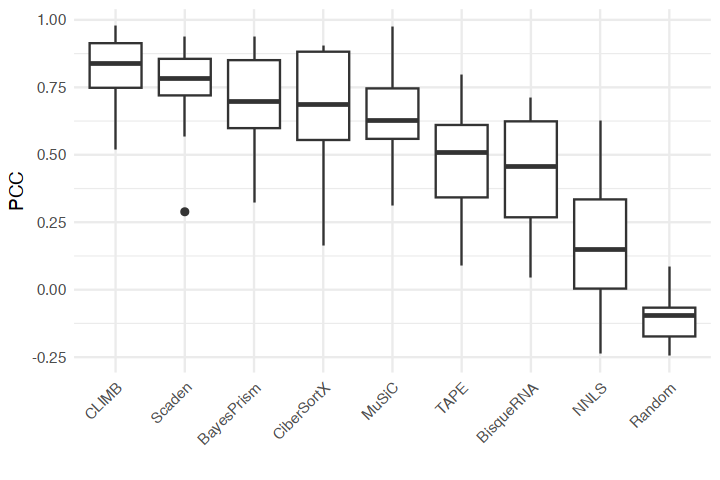

In [40]:
df.pcc = data.frame(do.call(rbind, accuracy.pcc.all_method), row.names = experiments_)
colnames(df.pcc) = c('CLIMB','NNLS', 'BisqueRNA', 'MuSiC', 'Scaden', 'BayesPrism', 'CiberSortX', 'TAPE', 'Random')
df.rmse = data.frame(do.call(rbind, accuracy.rmse.all_method), row.names = experiments_)
colnames(df.rmse) = c('CLIMB','NNLS', 'BisqueRNA', 'MuSiC', 'Scaden', 'BayesPrism', 'CiberSortX', 'TAPE', 'Random')

df.pcc.m = melt(df.pcc)
agg_ = aggregate(df.pcc.m$value, list(df.pcc.m$variable), median)
agg_ = agg_[order(-agg_$x),]
df.pcc.m$variable = factor(df.pcc.m$variable, levels = agg_$`Group.1`)

ggplot(df.pcc.m) + geom_boxplot(aes(x=variable, y=value)) + theme_minimal() +
    theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + 
    xlab('') + ylab('PCC')

No id variables; using all as measure variables



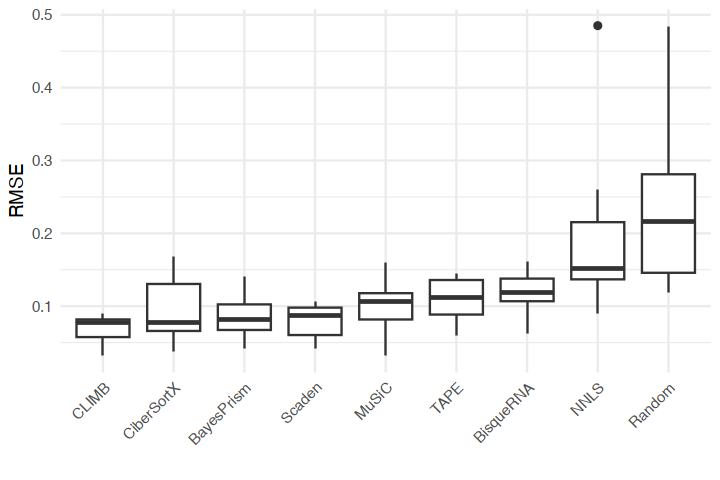

In [41]:
df.rmse.m = melt(df.rmse)
agg_ = aggregate(df.rmse.m$value, list(df.rmse.m$variable), median)
agg_ = agg_[order(agg_$x),]
df.rmse.m$variable = factor(df.rmse.m$variable, levels = agg_$`Group.1`)

ggplot(df.rmse.m) + geom_boxplot(aes(x=variable, y=value)) + theme_minimal() +
    theme(legend.position="none", axis.text.x = element_text(angle = 45, hjust=1.0, vjust=1.0)) + 
    xlab('') + ylab('RMSE')

In [53]:
# AML
out_dir = 'data/invitro_experiment/tables/'
ranks.invitro = rank_all_metrics(make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv')))
aml.na2vg = make_all_metrics(load_all_props('data/pseudobulks_climb/AML_na2vg', include_cibersortx=T), 'data/pseudobulks_climb/AML_na2vg/true_prop.csv') #, include_cibersortx=T
aml.vg2na = make_all_metrics(load_all_props('data/pseudobulks_climb/AML_vg2na', include_cibersortx=T), 'data/pseudobulks_climb/AML_vg2na/true_prop.csv')
ranks.vg2na = rank_all_metrics(aml.vg2na)
ranks.na2vg = rank_all_metrics(aml.na2vg)

# CRC
out_dir = 'data/pseudobulks_climb/CRC_kha2lee'
crc.kha2lee = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/CRC_lee2kha'
crc.lee2kha = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
# Compute rank over 4 metrics
ranks.kha2lee = rank_all_metrics(crc.kha2lee)
ranks.lee2kha = rank_all_metrics(crc.lee2kha)

# MEL
out_dir = 'data/pseudobulks_climb/MEL_jer2tir/'
mel.jer2tir = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/MEL_tir2jer/'
mel.tir2jer = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
# Compute rank over 4 metrics
ranks.jer2tir = rank_all_metrics(mel.jer2tir)
ranks.tir2jer = rank_all_metrics(mel.tir2jer)

# BREAST
out_dir = 'data/pseudobulks_climb/BREAST_gray2wu/'
breast.gray2wu = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/BREAST_wu2gray/'
breast.wu2gray = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
ranks.gray2wu = rank_all_metrics(breast.gray2wu)
ranks.wu2gray = rank_all_metrics(breast.wu2gray)

# GBM
out_dir = 'data/pseudobulks_climb/GBM_SS2tenX'
gbm.ss2tenx = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
out_dir = 'data/pseudobulks_climb/GBM_10x2ss2'
gbm.tenx2ss = make_all_metrics(load_all_props(out_dir, include_cibersortx = T), paste0(out_dir, '/true_prop.csv'))
ranks.ss2tenx = rank_all_metrics(gbm.ss2tenx)
ranks.tenx2ss = rank_all_metrics(gbm.tenx2ss)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE

Warning message in file(file, "rt"):
“cannot open file 'data/pseudobulks_climb/AML_na2vg/climb_prop_corrected.csv': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


In [43]:
mat_ranks = as.matrix(cbind(ranks.vg2na, ranks.na2vg, ranks.invitro, # ranks.vg2na_200sim,  # AML comparison
                     ranks.kha2lee, ranks.lee2kha, # CRC comparison
                     ranks.jer2tir, ranks.tir2jer, # MEL comparison
                     ranks.gray2wu, ranks.wu2gray, # BREAST comparison
                     ranks.ss2tenx, ranks.tenx2ss)) # GBM comparison

df_all.merge = data.frame(mean_overall = rowMeans(mat_ranks))
df_all.merge$std_overall = rowSds(mat_ranks)
df_all.merge$vg2na = rowMeans(as.matrix(ranks.vg2na))
df_all.merge$na2vg = rowMeans(as.matrix(ranks.na2vg))
#df_all.merge$na2vg_200sim = rowMeans(as.matrix(ranks.vg2na_200sim))
df_all.merge$invitro = rowMeans(as.matrix(ranks.invitro))
df_all.merge$kha2lee = rowMeans(as.matrix(ranks.kha2lee))
df_all.merge$lee2kha = rowMeans(as.matrix(ranks.lee2kha))
df_all.merge$jer2tir = rowMeans(as.matrix(ranks.jer2tir))
df_all.merge$tir2jer = rowMeans(as.matrix(ranks.tir2jer))
df_all.merge$gray2wu = rowMeans(as.matrix(ranks.gray2wu))
df_all.merge$wu2gray = rowMeans(as.matrix(ranks.wu2gray))
df_all.merge$ss2tenx = rowMeans(as.matrix(ranks.ss2tenx))
df_all.merge$tenx2ss = rowMeans(as.matrix(ranks.tenx2ss))
df_all.merge$method = rownames(df_all.merge)
df_all.merge$method = factor(df_all.merge$method, levels=rev(df_all.merge$method[order(df_all.merge$mean_overall)])) #[c(2,1,3:9)]

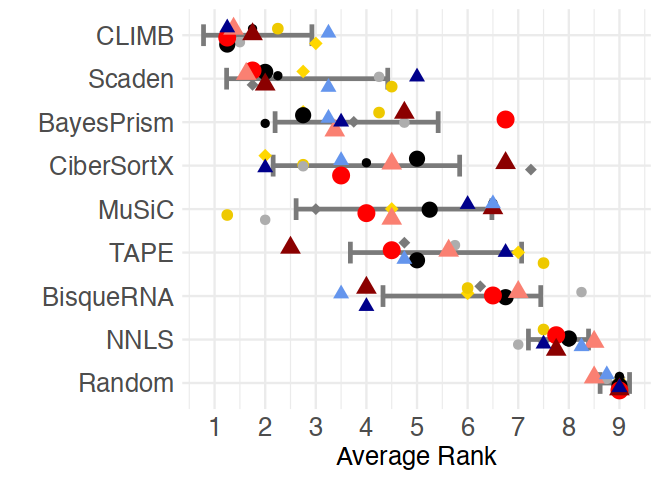

In [44]:
options(repr.plot.width=5.5, repr.plot.height=4)
g <- ggplot(data=df_all.merge) + 
    geom_errorbar(aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="grey48") +
    #geom_point(aes(x=mean_overall, y=method), size=5.0, color='grey28') + 

    geom_point(aes(x=jer2tir, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='gold1', shape=18)+
    geom_point(aes(x=tir2jer, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='gold2', shape=20)+
    geom_point(aes(x=gray2wu, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='grey48', shape=18)+
    geom_point(aes(x=wu2gray, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='grey68', shape=20)+
    geom_point(aes(x=ss2tenx, y=method), position = position_jitter(w = 0, h = 0.25), size=2.5, color='black', shape=20)+
    geom_point(aes(x=tenx2ss, y=method), position = position_jitter(w = 0, h = 0.25), size=3.5, color='black', shape=19)+
    geom_point(aes(x=vg2na, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='red') + 
    geom_point(aes(x=na2vg, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='darkred', shape=17)+
    #geom_point(aes(x=na2vg_200sim, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='darkred', shape=18)+
    geom_point(aes(x=invitro, y=method), position = position_jitter(w = 0, h = 0.25), size=4, color='salmon', shape=17)+
    geom_point(aes(x=kha2lee, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='cornflowerblue', shape=17)+
    geom_point(aes(x=lee2kha, y=method), position = position_jitter(w = 0, h = 0.25), size=3, color='darkblue', shape=17)+
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "left")
#pdf('results/fig3/rank_dots_ALL_cross_analysis.pdf', width=6.5, height=4.5) ; g ; dev.off()
g

In [45]:
rownames(mat_ranks)[2]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[2,]))$p.value)
rownames(mat_ranks)[3]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[3,]))$p.value)
rownames(mat_ranks)[4]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[4,]))$p.value)
rownames(mat_ranks)[5]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[5,]))$p.value)
rownames(mat_ranks)[6]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[6,]))$p.value)
rownames(mat_ranks)[7]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[7,]))$p.value)
rownames(mat_ranks)[8]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[8,]))$p.value)

[1] "Scaden"

[1] 0.001235185

[1] "TAPE"

[1] 5.081782e-13

[1] "CiberSortX"

[1] 1.043527e-08

[1] "BayesPrism"

[1] 2.914939e-08

[1] "MuSiC"

[1] 2.152934e-09

[1] "NNLS"

[1] 8.870919e-17

[1] "BisqueRNA"

[1] 1.449678e-14

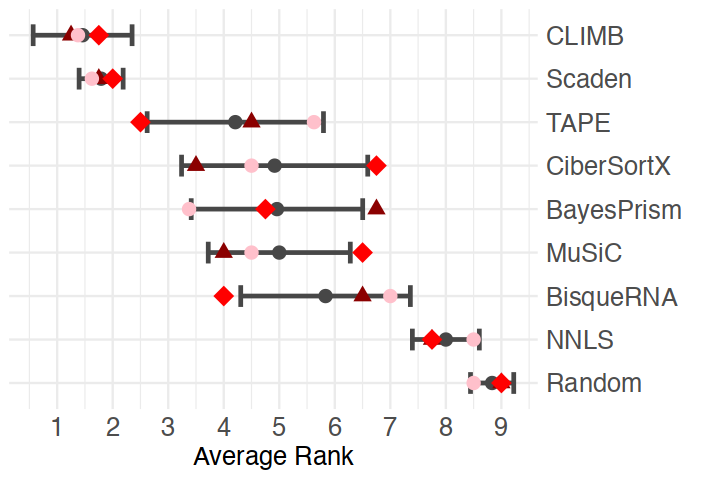

In [46]:
df_all = cbind(ranks.vg2na, ranks.na2vg, ranks.invitro) #ranks.vg2na_200sim
mat_ranks = as.matrix(df_all)
df_all$mean_overall = rowMeans(mat_ranks)
df_all$std_overall = rowSds(mat_ranks)
df_all$mean_inter1 = rowMeans(as.matrix(ranks.vg2na))
df_all$mean_inter2 = rowMeans(as.matrix(ranks.na2vg))
#df_all$mean_inter3 = rowMeans(as.matrix(ranks.vg2na_200sim))
df_all$mean_inter4 = rowMeans(as.matrix(ranks.invitro))

df_all$method = rownames(df_all)
df_all$method = factor(df_all$method, levels=rev(df_all$method[order(df_all$mean_overall)]))
df_all = df_all[,13:dim(df_all)[2]]

options(repr.plot.width=6, repr.plot.height=4)
g <- ggplot() + geom_errorbar(data=df_all, aes(y=method, xmin=mean_overall-std_overall, xmax=mean_overall+std_overall), width=0.5, size=1, color="grey28") +
    geom_point(data=df_all, aes(x=mean_overall, y=method), , size=3.0, color='grey28') + 
    geom_point(data=df_all, aes(x=mean_inter1, y=method), size=3.5, color='darkred', shape=17) +
    geom_point(data=df_all, aes(x=mean_inter2, y=method), size=5.5, color='red', shape=18) +
    #geom_point(data=df_all, aes(x=mean_inter3, y=method), size=3.5, color='salmon') +
    geom_point(data=df_all, aes(x=mean_inter4, y=method), size=3.0, color='pink') +
    scale_x_continuous(breaks=1:9) + 
    theme_minimal() + theme(axis.text=element_text(size = 15), text=element_text(size = 15)) + xlab('Average Rank') +
    ylab('') + scale_y_discrete(position = "right")
#pdf('results/fig3/rankings_AML_context_crossdatasets_4analysis.pdf', width=4.5, height=4.5) ; g ; dev.off()
g

In [47]:
rownames(mat_ranks)[2]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[2,]))$p.value)
rownames(mat_ranks)[3]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[3,]))$p.value)
rownames(mat_ranks)[4]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[4,]))$p.value)
rownames(mat_ranks)[5]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[5,]))$p.value)
rownames(mat_ranks)[6]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[6,]))$p.value)
rownames(mat_ranks)[7]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[7,]))$p.value)
rownames(mat_ranks)[8]
suppressWarnings(wilcox.test(num(mat_ranks[1,]), num(mat_ranks[8,]))$p.value)

[1] "Scaden"

[1] 0.03140946

[1] "TAPE"

[1] 0.0003941155

[1] "CiberSortX"

[1] 6.603273e-05

[1] "BayesPrism"

[1] 6.010613e-05

[1] "MuSiC"

[1] 4.4366e-05

[1] "NNLS"

[1] 1.781635e-05

[1] "BisqueRNA"

[1] 4.033256e-05

## Launch all deconvolution methods 

This process takes a long time. We recommend launching one analysis at the time with the following code. the single-cell reference dataset and matched pseudo-bulk datasets input RDS object can be define below. Then, the function `launch_all_deconvolution_methods` will run all methods.

Hereafter is the script that will launch all deconvolution methods in parallel. It writes all the results in the target directory, which can then be loaded with function `load_all_props`.

__Warning: This needs to have the environment 'tape_scaden_env' setup and accessible on the root of the folder. See README.md for setting up the environment. Also, upon Scaden run figures will pop up and needs to be closed for Scaden to run, otherwise it freezes... (It's possible de change Scaden source code to avoid this, see README.md)__

In [7]:
# The following two variables can be changed to use any of the twelves above
singlecell_reference = "data/pseudobulks_climb/AML_vangalen_sc_es.RDS"
pseudobulk_target = "data/pseudobulks_climb/AML_naldini_pbulks_vg_labs.RDS"

# Load ExpressionSet object containing scRNA-seq data from in-vitro cell mixes
sc.es = readRDS(singlecell_reference)
sc.es$cellType = reformat_celltypes(sc.es$cellType_original)
celltype_names = levels(sc.es$cellType)
# Load ExpressionSet object containing bulk RNA-seq data from in-vitro cell mixes
bulk.es = readRDS(pseudobulk_target)
# Load True cell line proportions (based on the volume of homogeneised cells pippeted in the mixture)
true_prop = as.matrix(pData(bulk.es))
colnames(true_prop) = reformat_strings(colnames(true_prop))

In [8]:
# define output directory and temp directory
out_dir = 'data/pseudobulks_climb/AML_vg2na/' ; tmp_dir = paste0(out_dir, '/tmp_tabs')
dir.create(tmp_dir, showWarnings = FALSE, recursive = TRUE)

In [9]:
# Write true proportions and celltype names in output folder for later usage
write.csv(celltype_names, paste0(out_dir, 'celltype_names.csv'), quote=F)
write.csv(true_prop, paste0(out_dir, 'true_prop.csv'), quote=F)

In [ ]:
launch_all_deconvolution_methods(sc = sc.es, bulks = bulk.es, true_prop = true_prop,
                                 celltype_names = celltype_names, out_dir = out_dir)

In [14]:
# Load all results for a given experiement in out_dir
all_props = load_all_props(out_dir, true_prop, celltype_names)

Checking that all tables have the same cell-type labels: TRUE

Checking that all tables has the same sample names: TRUE



In [15]:
# Compute accuracy metrics(PCC, SCC, RMSE, R2) for all deconvolution methods 
all_res = make_all_metrics(all_props, true_prop)

In [23]:
# Exemple to display some results
# Median RMSE
median(all_res$Scaden[[4]])
# Median Pearson Correlation Coef. (PCC)
median(all_res$Scaden[[1]])

[1] 0.09089792